In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

import tensorflow as tf
import math
import numpy as np
from matplotlib import pyplot as plt

from src.utils import reload_script

from models_src.Support import LRCallback
from models_src.fft_lib import xy_coords
from models_src.DETR import SinePositionEncoding, FFN, MHA
from models_src.window_queries import SinePositionEncodingFunc
from models_src.Attn_variations import SqueezeImg, UnSqueezeImg
from models_src.VecDataset import DatasetGenerator
from models_src.VecModels import VecLoss, clock_radial_enc, radial_dists, frequency_encoding, add_batch_dims, RadialEncoding, SeparateRadialEncoding, \
        FrequencyRadialEncoding, ExtractSampleLayer, DetectionMHA, ExpandDimsLayer, SampleFrequencyRadialEncoding

import cv2 as cv

%matplotlib inline

print(tf.config.list_physical_devices('GPU'))

2024-09-13 09:32:50.260945: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-13 09:32:50.513226: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-13 09:32:50.624761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-13 09:32:50.650255: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-13 09:32:50.857821: I tensorflow/core/platform/cpu_feature_guar

[]


2024-09-13 09:33:00.493932: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (100)


# Angle encoding

## experiments

In [5]:
yx = xy_coords((32,32))[...,::-1]
print(yx.shape)

(32, 32, 2)


In [3]:
sample_points = tf.constant(np.random.randint(0,32, (8,2)), dtype=tf.float32)

angles = tf.math.atan2(*tf.split(yx[tf.newaxis]-sample_points[:,tf.newaxis, tf.newaxis], 2, axis=-1))
print(angles.shape)

(8, 32, 32, 1)


## default sine encoding

In [115]:
size = 32
embs_size = 64
encodings = SinePositionEncodingFunc(dim=32, embs_size=embs_size, temperature=1e1)
encodings = tf.reshape(encodings, (size,size,embs_size))
print(encodings.shape)

(32, 32, 64)


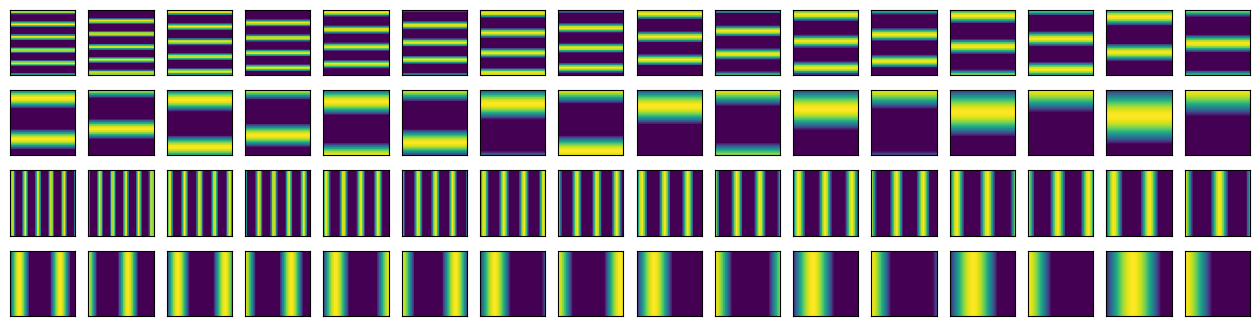

In [116]:
fig, axs = plt.subplots(4,16, figsize=(1*16, 1*4))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[...,i], vmin=0, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])

enc sum range:  31.017735
enc max range:  0.02439481


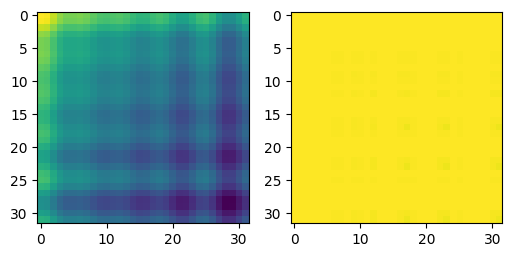

In [12]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings, axis=-1)
enc_max = tf.reduce_max(encodings, axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

## Radial enc

### separate radial enc

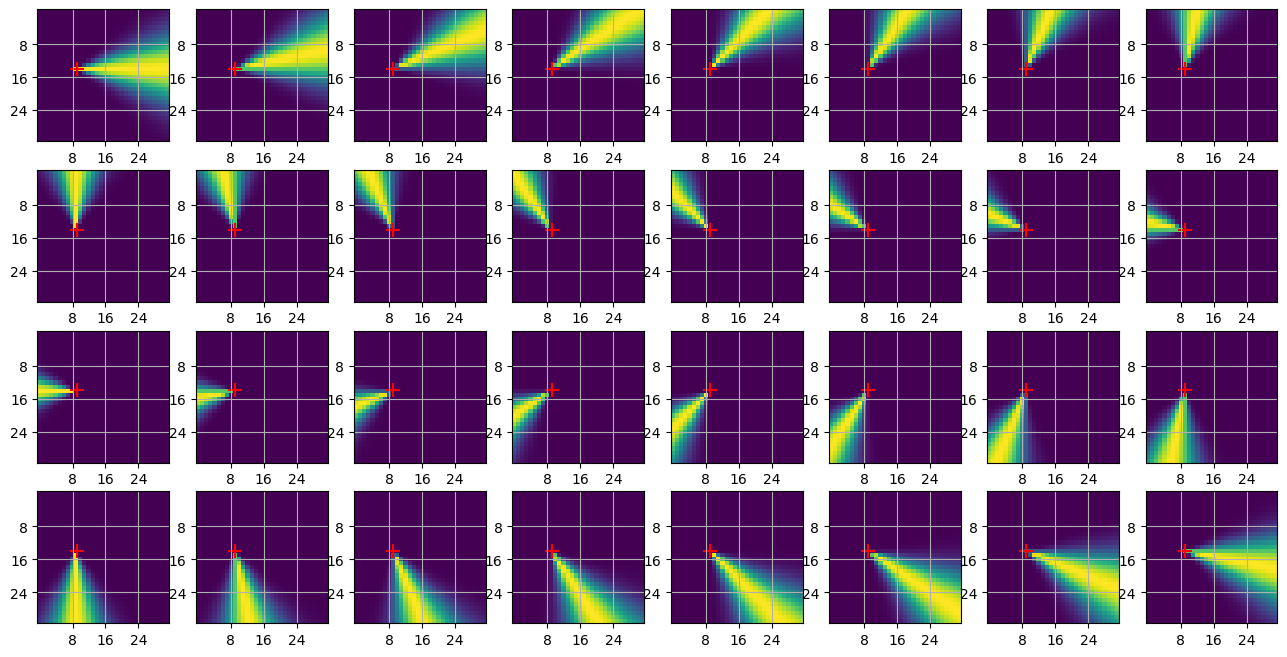

In [216]:
shifts_num = 32
encodings = clock_radial_enc(angles, shifts_num=shifts_num, period=2)

n = 0
cols = 8
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  4.2915344e-06
enc max range:  0.07299298


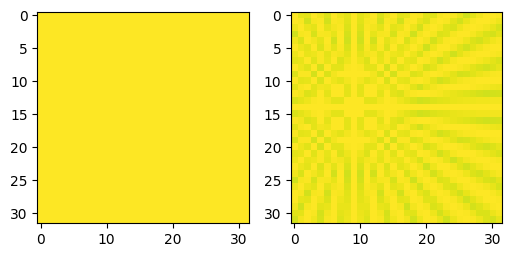

In [217]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n], axis=-1)
enc_max = tf.reduce_max(encodings[n], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum, vmin=0)
axs[1].imshow(enc_max, vmin=0, vmax=1)

### frequency radial enc

In [107]:
num_pos_features = 32
encodings = frequency_encoding(angles+math.pi/2, num_pos_features=num_pos_features, reg=1)
encodings = tf.reshape(tf.transpose(tf.reshape(encodings, (8,32,32,2,num_pos_features//2)), perm=[0,1,2,4,3]), (8,32,32,num_pos_features))

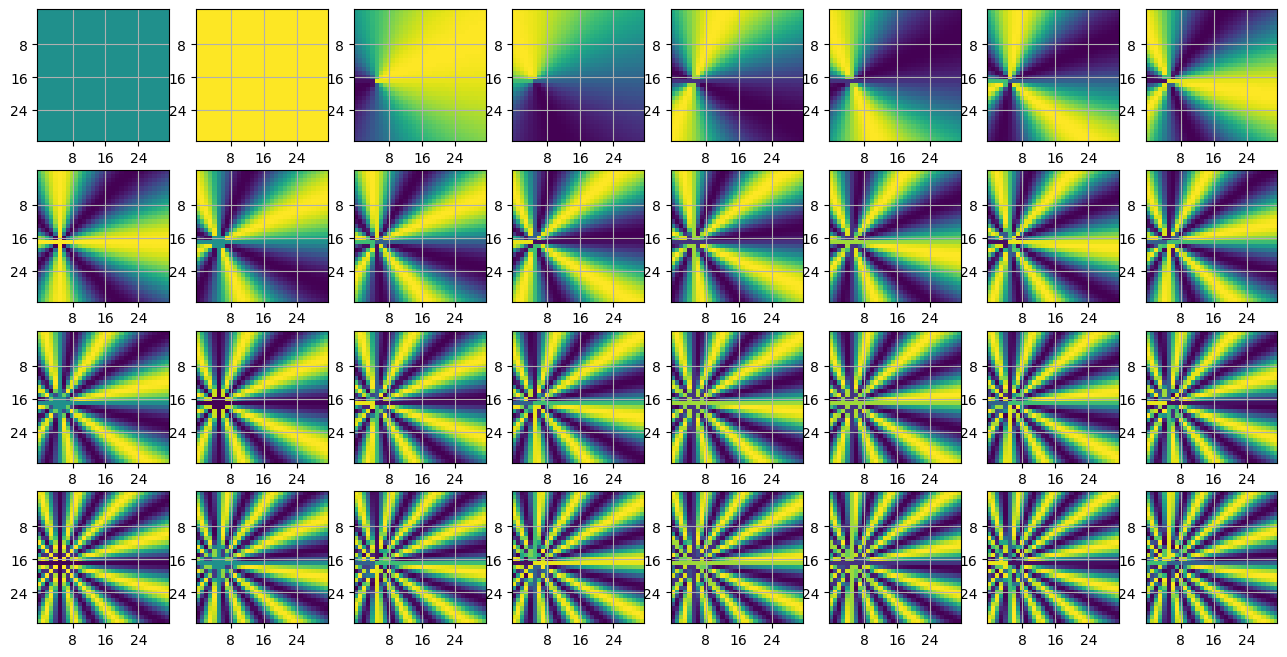

In [108]:
n=3
cols = 8
rows = num_pos_features//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=-1, vmax=1)
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

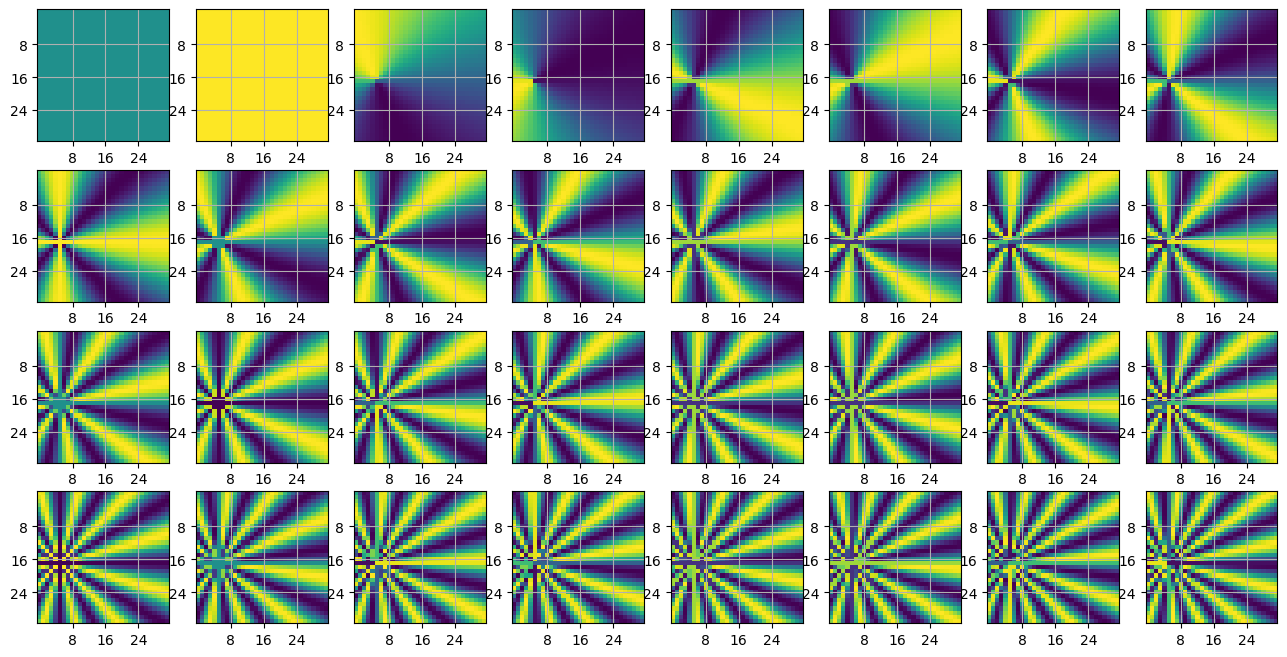

In [106]:
n=3
cols = 8
rows = num_pos_features//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=-1, vmax=1)
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  30.382748
enc max range:  0.042626977


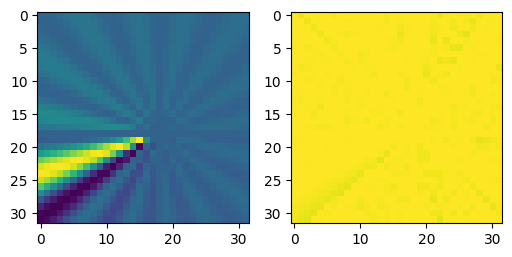

In [36]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,2:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,2:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

## Distance encoding

### separate ring enc

In [237]:
shifts_num = 32
size = 32

print(yx.shape, sample_points.shape)
dists = radial_dists(sample_points, yx, size)
print(dists.shape)

(32, 32, 2) (8, 2)
(8, 32, 32, 1)


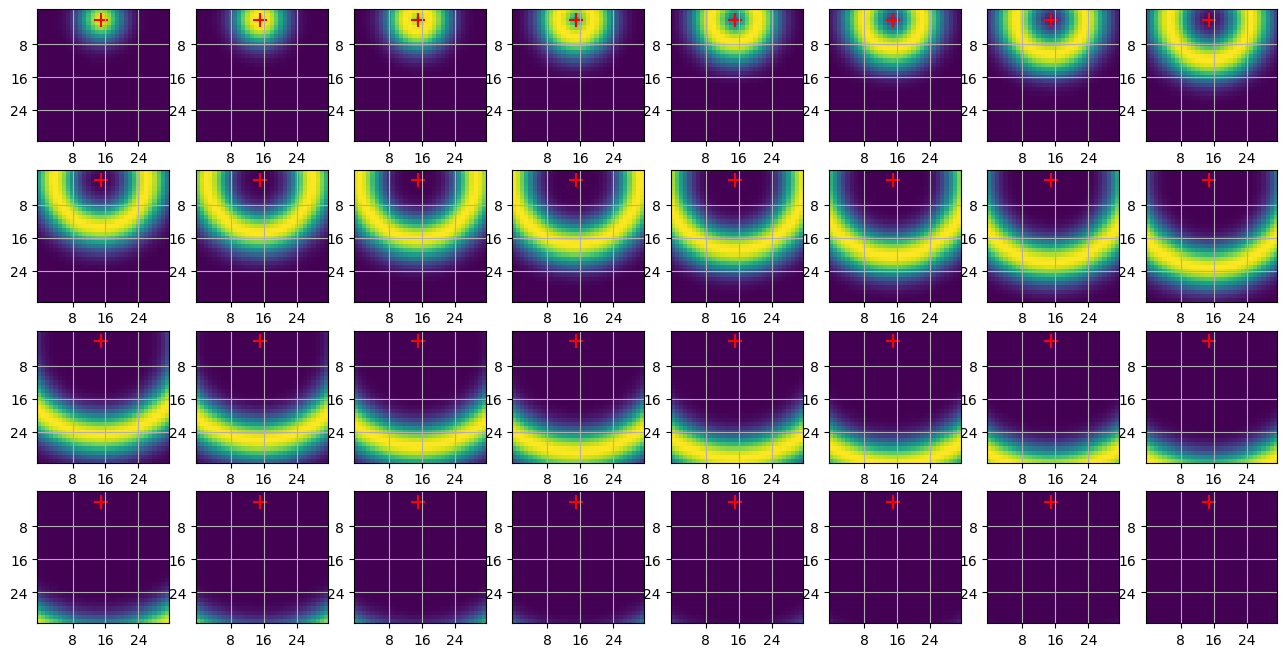

In [238]:
encodings = clock_radial_enc(dists, shifts_num, period=-1)

n = 1
cols = 8
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  2.6420913
enc max range:  0.018662214


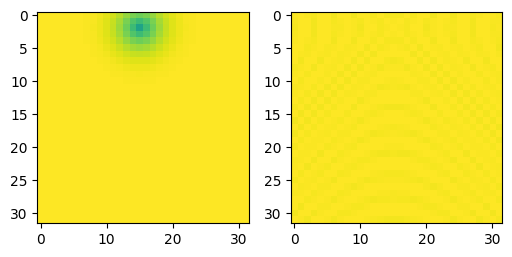

In [221]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n], axis=-1)
enc_max = tf.reduce_max(encodings[n], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum, vmin=0)
axs[1].imshow(enc_max, vmin=0, vmax=1)

### frequency ring enc

In [248]:
size = 32
num_pos_features = 32
r_embed = radial_dists(sample_points, yx, size)*2

encodings = frequency_encoding(r_embed, num_pos_features=num_pos_features)
encodings = tf.reshape(tf.transpose(tf.reshape(encodings, (8,32,32,2,num_pos_features//2)), perm=[0,1,2,4,3]), (8,32,32,num_pos_features))

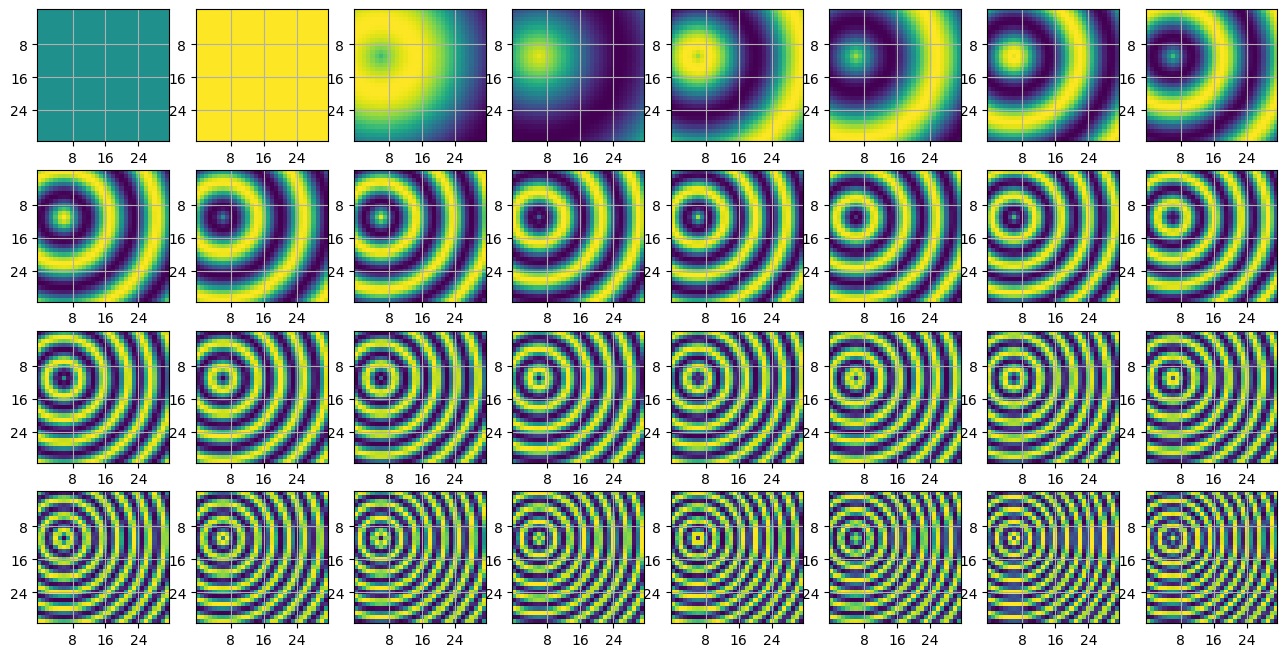

In [249]:
n=3
cols = 8
rows = num_pos_features//cols
fig, axs = plt.subplots(rows,cols, figsize=(2*cols, 2*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=-1, vmax=1)
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid()

enc sum range:  5.8787293
enc max range:  0.040088415


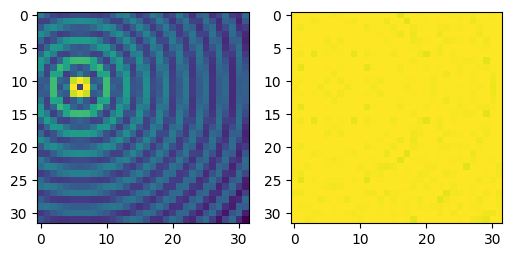

In [250]:
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,2:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,2:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

## Mixed encodings

### separate

In [47]:
shifts_num = 32
size = 32

dists = radial_dists(sample_points, yx, size)

ring_encodings = clock_radial_enc(dists, shifts_num, period=-1)
angle_encodings = clock_radial_enc(angles, shifts_num=shifts_num, period=2)

encodings = tf.concat([ring_encodings, angle_encodings], axis=-1)

In [62]:
encodings = SeparateRadialEncoding(emb_dim=64, height=32)(sample_points)
print(encodings.shape)

(8, 32, 32, 64)


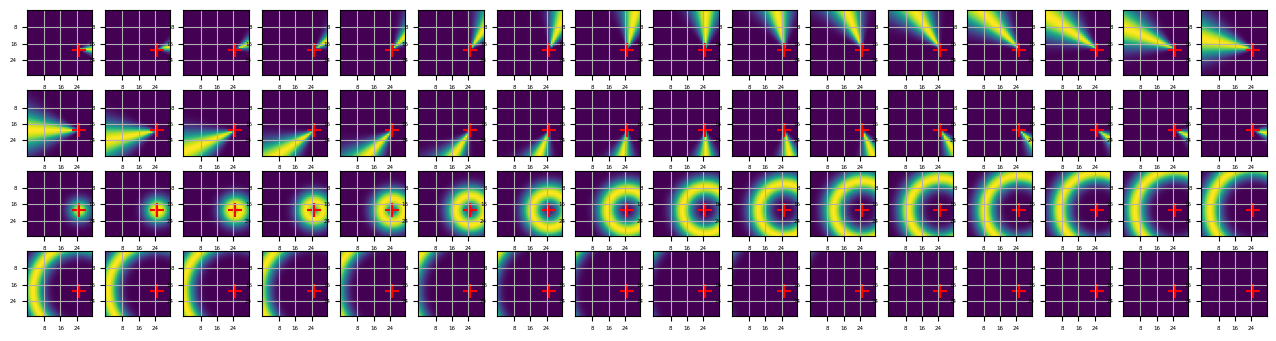

In [63]:
n = 1
shifts_num = encodings.shape[-1]
cols = 16
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(1*cols, 1*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='major', labelsize=4)
    ax.grid()

enc sum range:  2.6420937
enc max range:  0.01859194


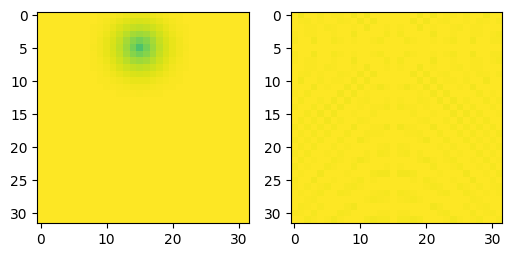

In [55]:
n=0
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,0:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,0:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum, vmin=0)
axs[1].imshow(enc_max, vmin=0, vmax=1)

### frequency

In [251]:
size = 32
num_pos_features = 32
r_embed = radial_dists(sample_points, yx, size)*2

ring_encodings = frequency_encoding(r_embed, num_pos_features=num_pos_features)
angle_encodings = frequency_encoding(angles+math.pi, num_pos_features=num_pos_features)

encodings = tf.concat([ring_encodings, angle_encodings], axis=-1)

In [64]:
encodings = FrequencyRadialEncoding(emb_dim=64, height=32)(sample_points)
print(encodings.shape)

(8, 32, 32, 64)


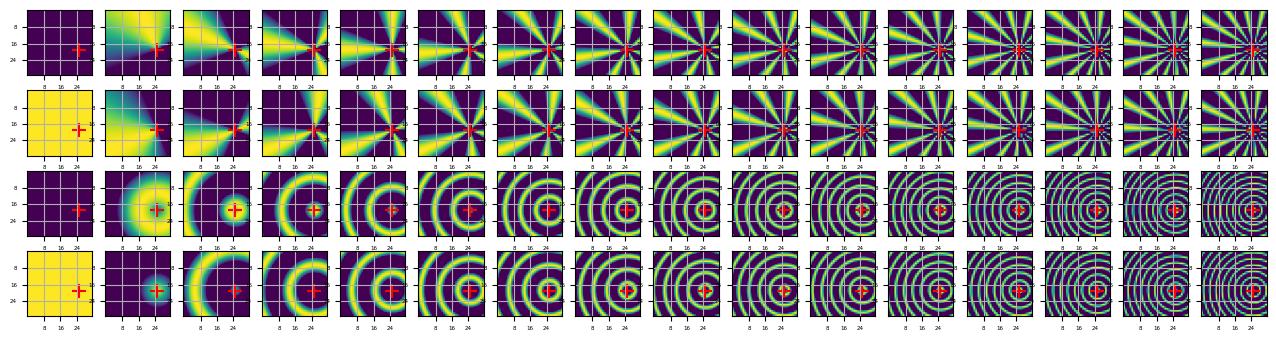

In [65]:
n = 1
shifts_num = encodings.shape[-1]
cols = 16
rows = shifts_num//cols
fig, axs = plt.subplots(rows,cols, figsize=(1*cols, 1*rows))

for i, ax in enumerate(axs.flat):
    ax.imshow(encodings[n,...,i], vmin=0, vmax=1)
    ax.scatter(*sample_points[n,::-1], marker='+', s=100, color='red')
    ax.set_xticks(np.arange(1,4)*8)
    ax.set_yticks(np.arange(1,4)*8)
    ax.tick_params(axis='both', which='major', labelsize=4)
    ax.grid()

enc sum range:  31.683395
enc max range:  0.0


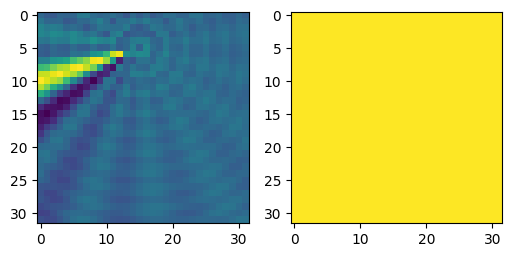

In [66]:
n=0
fig, axs = plt.subplots(1,2, figsize=(6,3))

enc_sum = tf.reduce_sum(encodings[n,...,2:], axis=-1)
enc_max = tf.reduce_max(encodings[n,...,2:], axis=-1)

print('enc sum range: ', np.max(enc_sum)-np.min(enc_sum))
print('enc max range: ', np.max(enc_max)-np.min(enc_max))

axs[0].imshow(enc_sum)
axs[1].imshow(enc_max, vmin=0, vmax=1)

# Validation

## Dataset

In [3]:
class SimpleLineMapGenerator():
    def __init__(self, size, thickness_range, randomize_range, extra_lines_range=None):

        self.size = size
        self.thickness_min, self.thickness_max = thickness_range
        self.randomize_range = randomize_range

        self.output_dtypes = [tf.float32, tf.int32, tf.int32]
        self.output_shapes = self.output_padded_shapes = [(size, size, 3), (2,), (2,2)]
        self.output_savenames = ['Aimg', 'Bsample_point', 'Clabel']

        self.outputs = ['img', 'sample_point', 'label']
        self.extra_lines_range = extra_lines_range

    def draw_random_line(self):

        img = np.zeros((self.size, self.size, 1), dtype=np.uint8)
        startpoint, endpoint = np.random.randint(0, self.size, (2,2))
        thickness = np.random.randint(self.thickness_min, self.thickness_max)

        img = cv.line(img, startpoint, endpoint, color=1, thickness=thickness)

        coords = np.stack(np.where(img>0)[:2], axis=-1)
        idx = np.random.randint(0, len(coords))
        sample_point = coords[idx]

        vec = np.stack([startpoint, endpoint], axis=0)[...,::-1]

        if self.extra_lines_range is not None:
            extra_lines_num = np.random.randint(*self.extra_lines_range)
            lines = np.random.randint(0, self.size, (extra_lines_num, 2,2))
            [cv.line(img, *v, 1, thickness) for v in lines]

        return img.astype(np.float32), sample_point.astype(np.int32), vec.astype(np.int32)

    def random_colors(self):
        randomize_shifts = np.random.uniform(-self.randomize_range, self.randomize_range, (self.size, self.size, 3))
        background_colors = np.random.uniform(0,1, (1, 1, 3))+randomize_shifts
        line_colors = np.random.uniform(0,1, (1,1,3))+randomize_shifts

        return tf.clip_by_value(background_colors.astype(np.float32), 0,1), tf.clip_by_value(line_colors.astype(np.float32), 0, 1)

    @tf.function
    def tf_random_line_img(self):
        line_mask, sample_point, label = tf.py_function(self.draw_random_line, [], Tout=[tf.float32, tf.int32, tf.int32])
        background_colors, line_colors = tf.py_function(self.random_colors, [], Tout=[tf.float32, tf.float32])

        img = background_colors*(1-line_mask) + line_colors*line_mask

        img.set_shape((self.size, self.size, 3))
        sample_point.set_shape((2,))
        label.set_shape((2,2))

        return img, tf.cast(sample_point, tf.int32), tf.cast(label, tf.int32)
    
    def __call__(self):
        return self.tf_random_line_img()
    
def output_formatter(img, sample_point, label):
    return (img, tf.cast(sample_point, tf.float32)), tf.cast(label, tf.float32)

In [4]:
slmg = SimpleLineMapGenerator(size=32, thickness_range=(1,3), randomize_range=0.1, extra_lines_range=(1,4))

In [5]:
dg = DatasetGenerator(slmg, 
                      ds_path='./datasets/pos_enc_test_multiline', 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=False, 
                      output_filter=None,
                      preprocess_funcs=[(output_formatter, {}, True)],
                      set_shapes=True
                      )


In [14]:
#dg.save_tfrec_dataset(folds_num=9, starting_num=0)


saving fold 1/9
   1/2048 ━━━━━━━━━━━━━━━━━━━━ 1:17 38ms/step

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step


2024-08-09 12:02:31.334516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



saving fold 2/9
2048/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

saving fold 3/9
  40/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

2024-08-09 12:02:39.792840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

saving fold 4/9
  38/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

2024-08-09 12:02:48.107230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step

saving fold 5/9
  51/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

2024-08-09 12:02:54.850603: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

saving fold 6/9
  28/2048 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step

2024-08-09 12:03:03.782043: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

saving fold 7/9
  38/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

2024-08-09 12:03:11.822417: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step

saving fold 8/9
  44/2048 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

2024-08-09 12:03:19.632490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step

saving fold 9/9
  45/2048 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step

2024-08-09 12:03:27.077238: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2048/2048 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


2024-08-09 12:03:34.635920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
ds, train_steps = dg.dataset(from_saved=True, batch_size=32, validation=False, val_idxs=[0], shuffle_buffer_size=128)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=256, validation=True, val_idxs=[0], shuffle_buffer_size=128)
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=8, validation=True, val_idxs=[0], shuffle_buffer_size=128)
ds_iter = iter(ds)
test_iter = iter(test_ds)

(32, 32, 32, 3) (32, 2) (32, 2, 2)


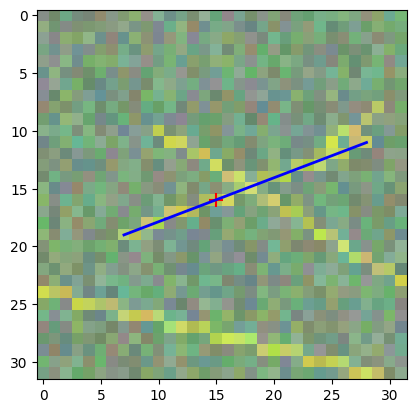

In [7]:
features, vec = next(ds_iter)
img, sample_point = features
print(img.shape, sample_point.shape, vec.shape)

plt.imshow(img[0])
plt.plot(*np.transpose(vec[0], axes=[1,0])[::-1], color='blue', linewidth=2)
plt.scatter(*sample_point[0,::-1], marker='+', color='red', s=100)

# Models

In [8]:
model_args = {
    'size': 32,
    'color_embs': 16,
    'conv_layers': 3,
    'kernel_size': 3,
    'embs_dim': 64,
    'mid_layers': 3,
    'out_mid_layers': 3,
    'out_units': 32,
    'corection_mid_layers': 2,
    'corection_units': 32,
    'num_heads': 1,
    'activation': 'relu',
    'temperature': 1e1
}

## default sine encoding

In [12]:
def gen_sine_enc_model(size, color_embs, conv_layers, kernel_size, embs_dim, mid_layers, out_mid_layers, out_units, corection_mid_layers, corection_units, num_heads, activation, dropout, temperature, **kwargs):
    img_inputs = tf.keras.layers.Input((size, size,3))
    sample_inputs = tf.keras.layers.Input((2,))

    features = tf.keras.layers.BatchNormalization()(img_inputs)
    color_features = FFN(mid_layers=mid_layers, mid_units=color_embs*2, output_units=color_embs, dropout=dropout, activation=activation)(features)

    conv_units = embs_dim-color_embs
    for _ in range(conv_layers):
        features = tf.keras.layers.Conv2D(conv_units, kernel_size=kernel_size, padding='same', activation=activation)(features)

    features = tf.keras.layers.Concatenate()([features, color_features])

    pos_enc = SinePositionEncoding(temperature=temperature)(features[...,0::num_heads])
    pos_enc = ExpandDimsLayer(axis=0)(pos_enc)

    sample_features = ExtractSampleLayer(batch_dims=1)(features, sample_inputs)
    sample_features = tf.keras.layers.Reshape((1, embs_dim))(sample_features)
    features = SqueezeImg()(features)

    x, _ = DetectionMHA(output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads)(features, sample_features, features, pos_enc)
    x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=out_units, dropout=dropout, activation=activation)(x)
    x = tf.keras.layers.Reshape((out_units,))(x)
    x = tf.keras.layers.Concatenate(axis=-1)([x, sample_inputs])
    x = FFN(mid_layers=corection_mid_layers, mid_units=corection_units, output_units=4, activation=activation)(x)
    x = tf.keras.layers.Reshape((2,2))(x)

    return tf.keras.Model((img_inputs, sample_inputs), x)

In [13]:
sine_model = gen_sine_enc_model(**model_args, dropout=0.2)
sine_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      1,344 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     20,784 │ conv2d_3[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     20,784 │ conv2d_4[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_1 (FFN)         │ (None, 32, 32,    │      2,768 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_5[0][0],   │
│ (Concatenate)       │ 64)               │            │ ffn_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 32, 32,    │          0 │ concatenate_1[0]… │
│ (GetItem)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_sample_lay… │ (None, 64)        │          0 │ concatenate_1[0]… │
│ (ExtractSampleLaye… │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sine_position_enco… │ (1024, 64)        │          0 │ get_item_1[0][0]  │
│ (SinePositionEncod… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_1       │ (None, 1024, 64)  │          0 │ concatenate_1[0]… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 64)     │          0 │ extract_sample_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expand_dims_layer_1 │ (1, 1024, 64)     │          0 │ sine_position_en… │
│ (ExpandDimsLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ detection_mha_1     │ [(None, 1, 64),   │     16,640 │ squeeze_img_1[0]… │
│ (DetectionMHA)      │ (None, 1, 1,      │            │ reshape_2[0][0],  │
│                     │ 1024)]            │            │ squeeze_img_1[0]… │
│                     │                   │            │ expand_dims_laye… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_2 (FFN)         │ (None, 1, 32)     │     45,472 │ detection_mha_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, 32)        │          0 │ ffn_2[0][0]     

 Total params: 110,112 (430.12 KB)

 Trainable params: 110,106 (430.10 KB)

 Non-trainable params: 6 (24.00 B)

In [14]:
sine_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = VecLoss(reduction='sum_over_batch_size')
)

In [15]:
sine_history = sine_model.fit(ds, epochs=20, steps_per_epoch=train_steps, validation_data=val_ds, validation_steps=val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/20


I0000 00:00:1723197992.167806   77612 service.cc:145] XLA service 0x7f119001e380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723197992.168378   77612 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-08-09 12:06:32.331709: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-09 12:06:32.994193: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  3/512 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - loss: 23.0517   

I0000 00:00:1723198005.024376   77612 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


510/512 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 10.9570

I0000 00:00:1723198011.378735   78594 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 16 bytes spill stores, 32 bytes spill loads

I0000 00:00:1723198011.476155   78596 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 372 bytes spill stores, 372 bytes spill loads

I0000 00:00:1723198011.537919   78601 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 360 bytes spill stores, 360 bytes spill loads

I0000 00:00:1723198012.079888   78602 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 20 bytes spill stores, 20 bytes spill loads

I0000 00:00:1723198012.506687   78598 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_9', 48 bytes spill stores, 64 bytes spill loads



512/512 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - loss: 10.9507 - val_loss: 9.3299 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 9.3710 - val_loss: 9.2154 - learning_rate: 9.0000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.2983 - val_loss: 9.2129 - learning_rate: 8.1000e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.2176 - val_loss: 9.2076 - learning_rate: 7.2900e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.2286 - val_loss: 9.1716 - learning_rate: 6.5610e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.1967 - val_loss: 9.2200 - learning_rate: 5.9049e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.1827 - val_loss: 9.1660 - learning_rate: 5.3144e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.1668 - val_loss: 9.1839 - learning_rate: 4.7830e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.1733 - val_loss: 9.1767 - learning_rat

## radial encoding

In [16]:
def gen_radial_enc_model(size, color_embs, conv_layers, kernel_size, embs_dim, mid_layers, out_mid_layers, out_units, corection_mid_layers, corection_units, num_heads, activation, dropout, temperature, enc_type, **kwargs):
    img_inputs = tf.keras.layers.Input((size, size,3))
    sample_inputs = tf.keras.layers.Input((2,))

    features = tf.keras.layers.BatchNormalization()(img_inputs)
    color_features = FFN(mid_layers=mid_layers, mid_units=color_embs*2, output_units=color_embs, dropout=dropout, activation=activation)(features)

    conv_units = embs_dim-color_embs
    for _ in range(conv_layers):
        features = tf.keras.layers.Conv2D(conv_units, kernel_size=kernel_size, padding='same', activation=activation)(features)

    features = tf.keras.layers.Concatenate()([features, color_features])

    if enc_type=='separate':
        pos_enc = SeparateRadialEncoding(emb_dim=embs_dim//num_heads, height=size)(sample_inputs)
    else:
        pos_enc = FrequencyRadialEncoding(emb_dim=embs_dim//num_heads, height=size)(sample_inputs)

    sample_features = ExtractSampleLayer(batch_dims=1)(features, sample_inputs)
    sample_features = tf.keras.layers.Reshape((1, embs_dim))(sample_features)
    features = SqueezeImg()(features)
    pos_enc = SqueezeImg()(pos_enc)

    x, _ = DetectionMHA(output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name='MHA')(features, sample_features, features, pos_enc)
    x = tf.keras.layers.Add()([sample_features, x])
    x = tf.keras.layers.LayerNormalization(axis=-1)(x)
    x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=4, dropout=dropout, activation=activation)(x)
    x = tf.keras.layers.Reshape((2,2))(x)

    sample_coords = tf.keras.layers.Reshape((1,2))(sample_inputs)
    x = tf.keras.layers.Add()([x, sample_coords])

    return tf.keras.Model((img_inputs, sample_inputs), x)

### separate encoding

In [17]:
sep_model = gen_radial_enc_model(**model_args, enc_type='separate', dropout=0.0)
sep_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ input_layer_8[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │      1,344 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │     20,784 │ conv2d_6[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     20,784 │ conv2d_7[0][0]    │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_4 (FFN)         │ (None, 32, 32,    │      2,768 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 32, 32,    │          0 │ conv2d_8[0][0],   │
│ (Concatenate)       │ 64)               │            │ ffn_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_sample_lay… │ (None, 64)        │          0 │ concatenate_3[0]… │
│ (ExtractSampleLaye… │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separate_radial_en… │ (None, 32, 32,    │          0 │ input_layer_9[0]… │
│ (SeparateRadialEnc… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 1, 64)     │          0 │ extract_sample_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_2       │ (None, 1024, 64)  │          0 │ concatenate_3[0]… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_3       │ (None, 1024, 64)  │          0 │ separate_radial_… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MHA (DetectionMHA)  │ [(None, 1, 64),   │     16,640 │ squeeze_img_2[0]… │
│                     │ (None, 1, 1,      │            │ reshape_6[0][0],  │
│                     │ 1024)]            │            │ squeeze_img_2[0]… │
│                     │                   │            │ squeeze_img_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 64)     │          0 │ reshape_6[0][0],  │
│                     │                   │            │ MHA[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 1, 64)     │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 104,320 (407.50 KB)

 Trainable params: 104,314 (407.48 KB)

 Non-trainable params: 6 (24.00 B)

In [18]:
sep_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = VecLoss(reduction='sum_over_batch_size')
)

In [19]:
sep_history = sep_model.fit(ds, epochs=20, steps_per_epoch=train_steps, validation_data=val_ds, validation_steps=val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 14s 11ms/step - loss: 9.1669 - val_loss: 6.6369 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 6.2132 - val_loss: 5.5935 - learning_rate: 9.0000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 5.4044 - val_loss: 5.1441 - learning_rate: 8.1000e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.9285 - val_loss: 4.6772 - learning_rate: 7.2900e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.4276 - val_loss: 4.3969 - learning_rate: 6.5610e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 4.0885 - val_loss: 3.9958 - learning_rate: 5.9049e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.8054 - val_loss: 3.8792 - learning_rate: 5.3144e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.5894 - val_loss: 3.8003 - learning_rate: 4.7830e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 3.4524 - val_loss: 3.6596 - le

### freq encoding

In [38]:
freq_model = gen_radial_enc_model(**model_args, enc_type='frequency', dropout=0.0)
freq_model.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24      │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32, 3) │         12 │ input_layer_24[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 32, 32,    │      1,344 │ batch_normalizat… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_18[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 32, 32,    │     20,784 │ conv2d_19[0][0]   │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ffn_12 (FFN)        │ (None, 32, 32,    │      2,768 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 32, 32,    │          0 │ conv2d_20[0][0],  │
│ (Concatenate)       │ 64)               │            │ ffn_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_25      │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ extract_sample_lay… │ (None, 64)        │          0 │ concatenate_7[0]… │
│ (ExtractSampleLaye… │                   │            │ input_layer_25[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ frequency_radial_e… │ (None, 32, 32,    │          0 │ input_layer_25[0… │
│ (FrequencyRadialEn… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_26          │ (None, 1, 64)     │          0 │ extract_sample_l… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_10      │ (None, 1024, 64)  │          0 │ concatenate_7[0]… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ squeeze_img_11      │ (None, 1024, 64)  │          0 │ frequency_radial… │
│ (SqueezeImg)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MHA (DetectionMHA)  │ [(None, 1, 64),   │     16,640 │ squeeze_img_10[0… │
│                     │ (None, 1, 1,      │            │ reshape_26[0][0], │
│                     │ 1024)]            │            │ squeeze_img_10[0… │
│                     │                   │            │ squeeze_img_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 1, 64)     │          0 │ reshape_26[0][0], │
│                     │                   │            │ MHA[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1, 64)     │        128 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 104,320 (407.50 KB)

 Trainable params: 104,314 (407.48 KB)

 Non-trainable params: 6 (24.00 B)

In [39]:
freq_model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-3),
    loss = VecLoss(reduction='sum_over_batch_size')
)

In [40]:
freq_history = freq_model.fit(ds, epochs=20, steps_per_epoch=train_steps, validation_data=val_ds, validation_steps=val_steps, callbacks=[
    LRCallback(warmup_lr=1e-5, warmup_epochs=0, decay_ratio=0.9)])

Epoch 1/20


512/512 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 9.2644 - val_loss: 6.4813 - learning_rate: 0.0010
Epoch 2/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 6.1712 - val_loss: 5.4665 - learning_rate: 9.0000e-04
Epoch 3/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 5.2201 - val_loss: 4.9363 - learning_rate: 8.1000e-04
Epoch 4/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.6247 - val_loss: 4.3923 - learning_rate: 7.2900e-04
Epoch 5/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 4.1447 - val_loss: 3.9458 - learning_rate: 6.5610e-04
Epoch 6/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.8189 - val_loss: 3.8751 - learning_rate: 5.9049e-04
Epoch 7/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.6336 - val_loss: 3.6044 - learning_rate: 5.3144e-04
Epoch 8/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.4148 - val_loss: 3.6909 - learning_rate: 4.7830e-04
Epoch 9/20
512/512 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 3.3170 - val_loss: 3.4689 - learning_rate

In [41]:
mha_output_model = tf.keras.Model(freq_model.inputs, freq_model.get_layer('MHA').output)

(32, 1, 1, 1024)


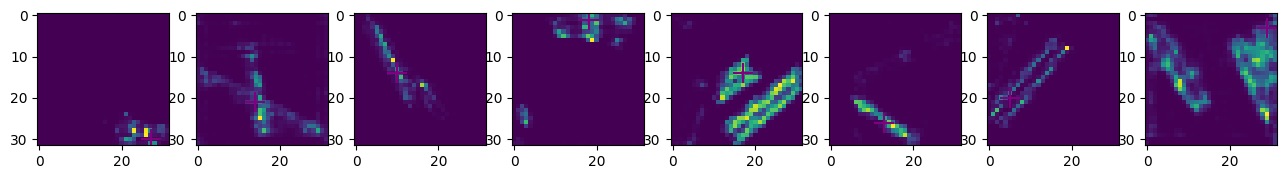

In [42]:
features, label_vec = next(ds_iter)
img, sample_point = features

x, scores = mha_output_model([img, sample_point])
print(scores.shape)
heads_num = scores.shape[1]
scores = tf.reshape(scores, (-1, heads_num, 32, 32))

s=8

fig, axs = plt.subplots(heads_num, 8, figsize=(8*2, heads_num*2))

for i in range(s):
    for j in range(heads_num):
        ax = axs[i,j] if heads_num>1 else axs[i]

        ax.imshow(scores[i,j])
        ax.scatter(*sample_point[i,::-1], marker='+', color='purple', s=200)
        

## test

sine loss:  5.761
separate loss:  3.341
frequency loss:  3.233


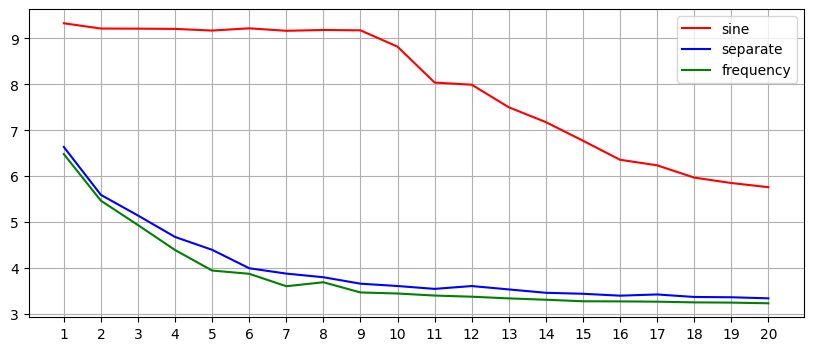

In [43]:
colors = ['red', 'blue', 'green']
plot_labels = ['sine', 'separate', 'frequency']
val_losses = [h.history['val_loss'] for h in [sine_history, sep_history, freq_history]]


plt.figure(figsize=(10,4))

x = list(range(1,21))
for h, clr, lbl in zip(val_losses, colors, plot_labels):
    print(f'{lbl} loss: ', np.round(h[-1], 3))
    plt.plot(x, h, color=clr, label=lbl)

plt.legend()
plt.xticks(x)
plt.grid()
plt.show()

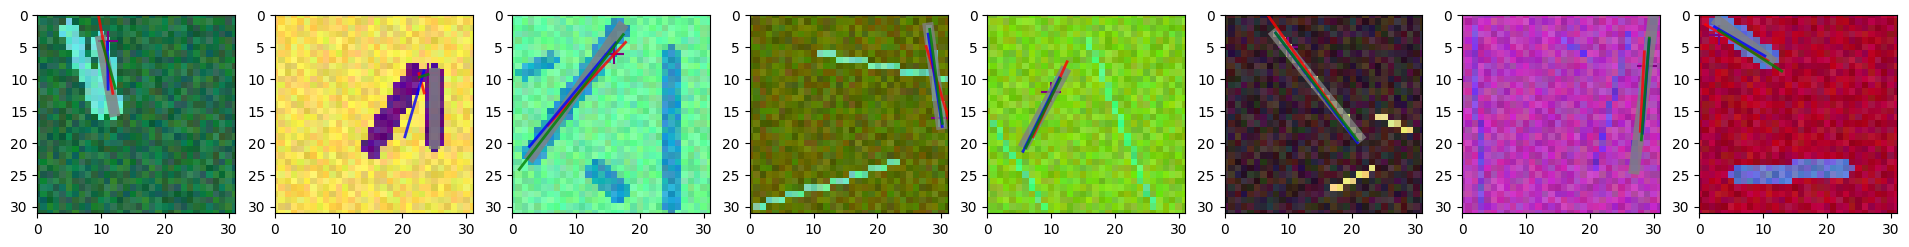

In [48]:
features, label_vec = next(ds_iter)
img, sample_point = features

sine_vec, sep_vec, freq_vec = [m([img, sample_point], training=False) for m in [sine_model, sep_model, freq_model]]

s=8

fig, axs = plt.subplots(1, s, figsize=(3*s, 3))

colors = ['gray', 'red', 'blue', 'green']
line_widths = [8,2,2,2]

for i, ax in enumerate(axs):
    ax.imshow(img[i])
    for clr, vec, lw in zip(colors, [v[i] for v in [label_vec, sine_vec, sep_vec, freq_vec]], line_widths):
        ax.plot(*np.transpose(vec, axes=[1,0])[::-1], color=clr, linewidth=lw, alpha=0.8)

    ax.scatter(*sample_point[i,::-1], marker='+', color='purple', s=200)

    ax.set_xlim(0,31)
    ax.set_ylim(31,0)

# Integral

In [4]:
import sympy as sp

In [132]:
x, y = sp.symbols('x y', real=True)
x0, y0 = sp.symbols('x0, y0', cls=sp.Idx)
freq, c, r = sp.symbols('omega c tau', real=True, constant=True)
ax, ay, bx1, by1, bx2, by2 = sp.symbols('a_x a_y b_x1 b_y1 b_x2 b_y2', real=True)

phase = (2*sp.pi*freq)/c
#angles = sp.atan2(y-y0, x-x0)+sp.pi
#angles = sp.symbols('alpha')
angles = sp.atan2(y,x)+r#sp.pi

expr = sp.sin((angles*freq) + phase)

expr

sin(omega*(tau + atan2(y, x)) + 2*pi*omega/c)

In [133]:
sp.Integral(sp.Integral(expr, (x, bx1, bx2)).as_sum(n=None, evaluate=False), (y,by1,by2)).as_sum(n=None, evaluate=False)

(-b_y1 + b_y2)*Sum((-b_x1 + b_x2)*Sum(sin(omega*(tau + atan2(_k*(-b_y1 + b_y2)/_n + b_y1 - (-b_y1 + b_y2)/(2*_n), _k*(-b_x1 + b_x2)/_n + b_x1 - (-b_x1 + b_x2)/(2*_n))) + 2*pi*omega/c), (_k, 1, _n))/_n, (_k, 1, _n))/_n

In [131]:
sp.Integral(sp.Integral(expr, (x, bx1, bx2)).as_sum(n=None, evaluate=False), (y,by1,by2)).as_sum(n=None, evaluate=False)

(-b_y1 + b_y2)*Sum((-b_x1 + b_x2)*Sum(cos(omega*(tau + atan2(_k*(-b_y1 + b_y2)/_n + b_y1 - (-b_y1 + b_y2)/(2*_n), _k*(-b_x1 + b_x2)/_n + b_x1 - (-b_x1 + b_x2)/(2*_n))) + 2*pi*omega/c), (_k, 1, _n))/_n, (_k, 1, _n))/_n

In [12]:
x, y = sp.symbols('x y', real=True)
x0, y0 = sp.symbols('x0, y0', cls=sp.Idx)
freq, c, s = sp.symbols('omega c s', real=True, constant=True)
ax, ay, bx1, by1, bx2, by2 = sp.symbols('a_x a_y b_x1 b_y1 b_x2 b_y2', real=True)

phase = (2*sp.pi*freq)/c
#angles = sp.atan2(y-y0, x-x0)+sp.pi
#angles = sp.symbols('alpha')
dists = sp.sqrt(y**2 + x**2)/s*sp.pi

expr = sp.cos((dists*freq) + phase)

expr

cos(pi*omega*sqrt(x**2 + y**2)/s + 2*pi*omega/c)

In [11]:
sp.Integral(sp.Integral(expr, (x, bx1, bx2)).as_sum(n=None, evaluate=False), (y,by1,by2)).as_sum(n=None, evaluate=False)

(-b_y1 + b_y2)*Sum((-b_x1 + b_x2)*Sum(sin(pi*omega*sqrt((_k*(-b_x1 + b_x2)/_n + b_x1 - (-b_x1 + b_x2)/(2*_n))**2 + (_k*(-b_y1 + b_y2)/_n + b_y1 - (-b_y1 + b_y2)/(2*_n))**2)/s + 2*pi*omega/c), (_k, 1, _n))/_n, (_k, 1, _n))/_n

In [13]:
sp.Integral(sp.Integral(expr, (x, bx1, bx2)).as_sum(n=None, evaluate=False), (y,by1,by2)).as_sum(n=None, evaluate=False)

(-b_y1 + b_y2)*Sum((-b_x1 + b_x2)*Sum(cos(pi*omega*sqrt((_k*(-b_x1 + b_x2)/_n + b_x1 - (-b_x1 + b_x2)/(2*_n))**2 + (_k*(-b_y1 + b_y2)/_n + b_y1 - (-b_y1 + b_y2)/(2*_n))**2)/s + 2*pi*omega/c), (_k, 1, _n))/_n, (_k, 1, _n))/_n

tf.Tensor(
[[ 8.  6.]
 [29. 11.]], shape=(2, 2), dtype=float32)
tf.Tensor(-103.392494, shape=(), dtype=float32)
tf.Tensor(
[[ 7.8660874 23.894228 ]
 [ 7.866089   2.3071947]], shape=(2, 2), dtype=float32)
(32, 32, 1) (32, 32, 1)
(32, 32, 32) (32, 32, 32)


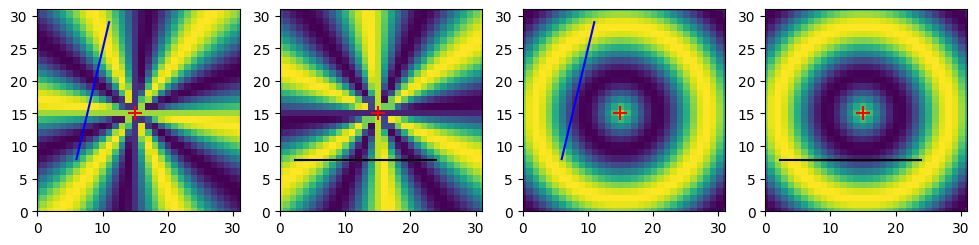

In [20]:
i=6
size = 32*2**0.5
sample_point = tf.constant([15,15], tf.float32)

vec = tf.constant(np.random.randint(0,32, (2,2)), tf.float32)
print(vec)
vec_angle = tf.math.atan2(*(vec[0]-vec[1]))
print(vec_angle/math.pi*180)

rot_matrix = tf.stack([tf.stack([tf.cos(vec_angle), -tf.sin(vec_angle)]),tf.stack([tf.sin(vec_angle), tf.cos(vec_angle)])])

rot_vec = tf.squeeze(tf.matmul(rot_matrix[tf.newaxis], (vec-sample_point[tf.newaxis])[...,tf.newaxis]), axis=-1)+sample_point[tf.newaxis]
print(rot_vec)

num_pos_features = 32

sample_angles = tf.math.atan2(*tf.split(yx-sample_point[tf.newaxis, tf.newaxis], 2, axis=-1))
sample_dists = tf.reduce_sum((yx-sample_point[tf.newaxis, tf.newaxis])**2, axis=-1, keepdims=True)**0.5/size*math.pi
print(sample_angles.shape, sample_dists.shape)

encodings = frequency_encoding(sample_angles+math.pi, num_pos_features=num_pos_features, reg=1)
rot_encodings = frequency_encoding(sample_angles+math.pi+vec_angle, num_pos_features=num_pos_features, reg=1)
ring_encodings = frequency_encoding(sample_dists, num_pos_features=num_pos_features)
print(encodings.shape, ring_encodings.shape)

fig, axs = plt.subplots(1,4, figsize=(12,3))

axs[0].imshow(encodings[...,i])
axs[0].scatter(*sample_point[::-1], color='red', marker='+', s=100)
axs[0].plot(*tf.transpose(vec, [1,0])[::-1], color='blue')

axs[1].imshow(rot_encodings[...,i])
axs[1].scatter(*sample_point[::-1], color='red', marker='+', s=100)
axs[1].plot(*tf.transpose(rot_vec, [1,0])[::-1], color='black')

axs[2].imshow(ring_encodings[...,i])
axs[2].scatter(*sample_point[::-1], color='red', marker='+', s=100)
axs[2].plot(*tf.transpose(vec, [1,0])[::-1], color='blue')

axs[3].imshow(ring_encodings[...,i])
axs[3].scatter(*sample_point[::-1], color='red', marker='+', s=100)
axs[3].plot(*tf.transpose(rot_vec, [1,0])[::-1], color='black')

for ax in axs:
    ax.set_xlim(0,31)
    ax.set_ylim(0,31)

In [21]:
np_vec = np.round(vec.numpy()[:,::-1], 0).astype(np.int32)
vec_mask = tf.constant(cv.line(np.zeros((32,32,1), np.int32), np_vec[0], np_vec[1], color=1), tf.float32)
print(vec_mask.shape)

pixel_angle_solution = tf.reduce_sum(vec_mask*encodings[...,:], axis=[0,1])
pixel_ring_solution = tf.reduce_sum(vec_mask*ring_encodings, axis=[0,1])

pixel_solution = tf.concat([pixel_angle_solution, pixel_ring_solution], axis=0)
print(pixel_solution)

(32, 32, 1)
tf.Tensor(
[  0.          -0.43206203  -1.3639097   -2.4083538   -2.4729376
  -0.92298317   1.4776571    2.9473252    2.2060585   -0.25245142
  -2.4142284   -2.4150543   -0.15791297   2.600211     3.7820761
   2.748115    22.          17.366512     6.41927     -4.129376
  -8.569363    -5.9107857    0.1099185    4.370861     4.179805
   0.67428386  -2.8378835   -3.7985153   -2.1222768    0.3414014
   1.6894045    1.4145489    0.          18.983795    17.946335
  -0.60998845 -16.12364    -14.163956    -0.25400543  10.269262
   9.810287     2.6626446   -3.8176665   -6.399553    -5.176156
  -1.0130953    3.9446974    6.098689    22.          10.622043
 -10.957962   -19.852325    -8.701257     8.453936    14.48757
   7.00644     -3.6365538   -8.320577    -6.3419423   -1.4372599
   3.3766475    6.020034     4.6906548   -0.15928376], shape=(64,), dtype=float32)


In [22]:
rel_vec = rot_vec-sample_point[tf.newaxis]
print(rel_vec)
by1, by2 = rel_vec[0,0]-0.5, rel_vec[1,0]+0.5
bx2, bx1 = rel_vec[:,1]
print([a.numpy() for a in [by1, by2, bx1, bx2]])

freq = tf.cast(tf.range(16), tf.float32)[:,tf.newaxis]
c = num_pos_features//2

def atan_vec_arg_riemanns(k, b1, b2, n):
    return k*(-b1+b2)/n + b1 - (-b1+b2)/(2*n)

def calc_vec_angle_integral(n, k, freq, c, r, bx1, bx2, by1, by2, func=tf.sin):
    return (-by1+by2)*(-bx1+bx2)*tf.reduce_sum(func(freq*(r + tf.math.atan2(atan_vec_arg_riemanns(k, by1, by2, n), atan_vec_arg_riemanns(k, bx1, bx2, n))) + 2*math.pi*freq/c), axis=-1)/n

def calc_vec_ring_integral(n, k, freq, c, s, bx1, bx2, by1, by2, func=tf.sin):
    return (-by1+by2)*(-bx1+bx2)*tf.reduce_sum(func(freq*math.pi*((atan_vec_arg_riemanns(k, by1, by2, n)**2 + atan_vec_arg_riemanns(k, bx1, bx2, n)**2)**0.5)/s + 2*math.pi*freq/c), axis=-1)/n

n = 8
k = tf.cast(tf.range(n)+1, tf.float32)
r = math.pi+vec_angle

sin_angle_is = calc_vec_angle_integral(n, k, freq, c, r, bx1, bx2, by1, by2, func=tf.sin)
cos_angle_is = calc_vec_angle_integral(n, k, freq, c, r, bx1, bx2, by1, by2, func=tf.cos)
sin_ring_is = calc_vec_ring_integral(n, k, freq, c, size, bx1, bx2, by1, by2, func=tf.sin)
cos_ring_is = calc_vec_ring_integral(n, k, freq, c, size, bx1, bx2, by1, by2, func=tf.cos)

integral_solution = tf.concat([sin_angle_is, cos_angle_is, sin_ring_is, cos_ring_is], axis=0)
print(integral_solution)

tf.Tensor(
[[ -7.1339126   8.894228 ]
 [ -7.133911  -12.692805 ]], shape=(2, 2), dtype=float32)
[-7.6339126, -6.633911, -12.692805, 8.894228]
tf.Tensor(
[  0.          -0.19208492  -1.327763    -3.0238888   -3.690208
  -2.087432     1.1812686    3.8130085    3.6560566    0.6743268
  -2.8100867   -3.9448586   -1.7047861    2.3026683    5.3104644
   5.8214927   21.587063    17.320763     7.136391    -2.9818585
  -7.8177733   -6.198296    -1.1016824    3.1165552    3.9480457
   1.9638557   -0.46689415  -1.4386925   -0.7501696    0.5906093
   1.652642     2.2336686    0.          18.469433    17.980768
   0.34187722 -15.368314   -14.749486    -1.7284636    9.4891615
  10.580359     4.220083    -2.963391    -7.0179787   -6.6644344
  -1.9411618    4.475274     7.4253383   21.587063    10.722316
 -10.207286   -19.580088    -9.63296      7.22314     14.441334
   8.332435    -2.2779589   -8.276718    -7.6253424   -2.8288422
   3.1655302    7.1663003    6.0109076   -0.05054196], shape=(64,), dty

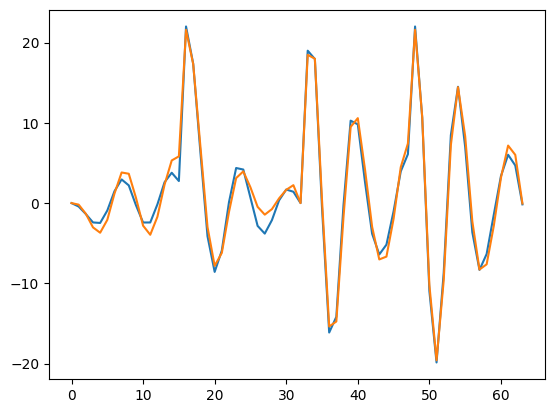

In [23]:
plt.plot(pixel_solution)
plt.plot(integral_solution)

In [8]:
1-tf.linalg.diag(tf.ones((4,)))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 1., 1., 1.],
       [1., 0., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.]], dtype=float32)>

## integral layers

In [51]:
def calc_single_integral_vec_encoding(sample_point, vec, size, yx, emb_size, linear=True):
    s = size*2**0.5
    num_pos_features = emb_size//2

    vec_angle = tf.math.atan2(*(vec[0]-vec[1]))

    rot_matrix = tf.stack([tf.stack([tf.cos(vec_angle), -tf.sin(vec_angle)]),tf.stack([tf.sin(vec_angle), tf.cos(vec_angle)])])

    sample_angles = tf.math.atan2(*tf.split(yx-sample_point[tf.newaxis, tf.newaxis], 2, axis=-1))
    sample_dists = tf.reduce_sum((yx-sample_point[tf.newaxis, tf.newaxis])**2, axis=-1, keepdims=True)**0.5/s*math.pi

    encodings = frequency_encoding(sample_angles+math.pi, num_pos_features=num_pos_features, reg=1)
    ring_encodings = frequency_encoding(sample_dists, num_pos_features=num_pos_features)

    np_vec = np.round(vec.numpy()[:,::-1], 0).astype(np.int32)
    drawing_func = cv.line if linear else cv.rectangle
    thickness = 1 if linear else -1
    vec_mask = tf.constant(drawing_func(np.zeros((size,size,1), np.int32), np_vec[0], np_vec[1], color=1, thickness=thickness), tf.float32)

    pixel_angle_solution = tf.reduce_sum(vec_mask*encodings[...,:], axis=[0,1])
    pixel_ring_solution = tf.reduce_sum(vec_mask*ring_encodings, axis=[0,1])

    return tf.concat([pixel_angle_solution, pixel_ring_solution], axis=0)/tf.reduce_sum(vec_mask), vec_mask

In [45]:
class IntegralVecRadialEncodingPreprcessing(tf.keras.layers.Layer):

    def build(self, input_shape):
        self.N = input_shape[1]

    @staticmethod
    def calc_vec_angle(x):
        return tf.math.atan2(*tf.split(tf.squeeze(tf.math.subtract(*tf.split(x, 2, axis=-2)), axis=-2), 2, axis=-1))
    
    @staticmethod
    def get_rotation_matrix(x):
        return tf.stack([tf.stack([tf.cos(x), -tf.sin(x)], axis=-1),tf.stack([tf.sin(x), tf.cos(x)], axis=-1)], axis=-2)
    
    @staticmethod
    def line_thickness_aplication(by1, by2, bx1, bx2, thickness):
        shift = thickness/2
        by1 -= shift
        by2 += shift

        return tf.stack([by1, bx1, by2, bx2], axis=-2)
    
    @staticmethod
    def shape_thickness_aplication(rel_vecs):
        y1x1 = tf.reduce_min(rel_vecs, axis=-3, keepdims=False)
        y2x2 = tf.reduce_max(rel_vecs, axis=-3, keepdims=False)
        return tf.concat([y1x1, y2x2], axis=-2)
    
    
    def call(self, sample_points, vec_pred, thickness_pred, class_pred_logit, training=None):

        vec_angle = self.calc_vec_angle(vec_pred)

        rot_matrix = tf.expand_dims(self.get_rotation_matrix(vec_angle), axis=1)

        rel_vecs = tf.expand_dims(tf.expand_dims(vec_pred, axis=1)-tf.expand_dims(tf.expand_dims(sample_points, axis=2), axis=3), axis=-1)

        rot_vecs = tf.squeeze(tf.matmul(rot_matrix, rel_vecs), axis=-1)
        r = tf.expand_dims(vec_angle+math.pi, axis=1)

        by1, bx2, by2, bx1 = tf.split(tf.reshape(rot_vecs, (-1,self.N, self.N, 4)), 4, axis=-1)
        thickness_pred = tf.expand_dims(thickness_pred, axis=1)

        line_rel_coords = self.line_thickness_aplication(by1, by2, bx1, bx2, thickness_pred)
        shape_rel_coords = self.shape_thickness_aplication(rel_vecs)

        class_probs = tf.expand_dims(tf.nn.softmax(class_pred_logit[...,1:], axis=-1), axis=1)

        return r, line_rel_coords, shape_rel_coords, class_probs
    

class IntegralVecRadialEncoding(tf.keras.layers.Layer):
    def __init__(self, emb_dim, riemann_samples, size, **kwargs):
        super().__init__(**kwargs)

        self.C = emb_dim
        self.c = emb_dim//4

        self.n = riemann_samples
        self.s = size*(2**0.5)

        self.k = tf.cast(tf.reshape(tf.range(riemann_samples)+1, (1,1,1,1,riemann_samples)), tf.float32)
        self.freq = tf.cast(tf.reshape(tf.range(self.c), (1,1,1,self.c,1)), tf.float32)

    def calc_vec_arg_riemanns(self, b1, b2):
        return self.k*(-b1+b2)/self.n + b1 - (-b1+b2)/(2*self.n)
    
    def calc_angle_angle_arg(self, y_vec_arg, x_vec_arg, r):
        return self.freq*(r + tf.math.atan2(y_vec_arg, x_vec_arg)) + 2*math.pi*self.freq/self.c
    
    def calc_ring_angle_arg(self, y_vec_arg, x_vec_arg):
        return self.freq*math.pi*((y_vec_arg**2 + x_vec_arg**2)**0.5)/self.s + 2*math.pi*self.freq/self.c
    
    def calc_prefix_arg(self, by1, by2, bx1, bx2):
        return tf.squeeze((-by1+by2)*(-bx1+bx2)/self.n, axis=-1)
    
    def calc_vec_integral(self, prefix_arg, angle_arg, func):
        return prefix_arg*tf.reduce_sum(func(angle_arg), axis=-1)
    
    @staticmethod
    def calc_field(coords):
        y1, x1, y2, x2 = tf.split(tf.squeeze(coords, axis=-1), 4, axis=-1)
        return (x2-x1)*(y2-y1)
        
    def call(self, r, rel_coords):
        if r is not None:
            r = tf.expand_dims(r, axis=-1)
        else:
            r = math.pi

        by1, bx1, by2, bx2 = tf.split(rel_coords, 4, axis=-2)

        y_vec_arg = self.calc_vec_arg_riemanns(by1, by2)
        x_vec_arg = self.calc_vec_arg_riemanns(bx1, bx2)
        prefix_arg = self.calc_prefix_arg(by1, by2, bx1, bx2)

        angle_angle_arg = self.calc_angle_angle_arg(y_vec_arg, x_vec_arg, r)
        ring_angle_arg = self.calc_ring_angle_arg(y_vec_arg, x_vec_arg)

        sin_angle = self.calc_vec_integral(prefix_arg, angle_angle_arg, tf.sin)
        cos_angle = self.calc_vec_integral(prefix_arg, angle_angle_arg, tf.cos)
        sin_ring = self.calc_vec_integral(prefix_arg, ring_angle_arg, tf.sin)
        cos_ring = self.calc_vec_integral(prefix_arg, ring_angle_arg, tf.cos)

        field = self.calc_field(rel_coords)

        return tf.concat([sin_angle, cos_angle, sin_ring, cos_ring], axis=-1)/field

In [46]:
B = 8
size = 32
yx = xy_coords((size,size))[...,::-1]
emb_size = 64
sample_points = 5

In [47]:
sample_inputs = tf.constant(np.random.randint(0,size,(B,sample_points,2)), tf.float32)
vec_pred = tf.constant(np.random.randint(0,size,(B,sample_points,2,2)), tf.float32)
thickness_pred = tf.constant(np.random.randint(1,2,(B,sample_points,1)), tf.float32)
class_pred_logits = tf.random.uniform((B,sample_points,3), -5, 5)

In [48]:
r, line_rel_coords, shape_rel_coords, class_probs = IntegralVecRadialEncodingPreprcessing()(sample_inputs, vec_pred, thickness_pred, class_pred_logits)
print(r.shape, line_rel_coords.shape, shape_rel_coords.shape, class_probs.shape)

(8, 1, 5, 1) (8, 5, 5, 4, 1) (8, 5, 5, 4, 1) (8, 1, 5, 2)


In [49]:
line_encoding = IntegralVecRadialEncoding(emb_dim=64, riemann_samples=8, size=size)(r, line_rel_coords)
shape_encoding = IntegralVecRadialEncoding(emb_dim=64, riemann_samples=8, size=size)(None, shape_rel_coords)
print(line_encoding.shape, shape_encoding.shape)

(8, 5, 5, 64) (8, 5, 5, 64)


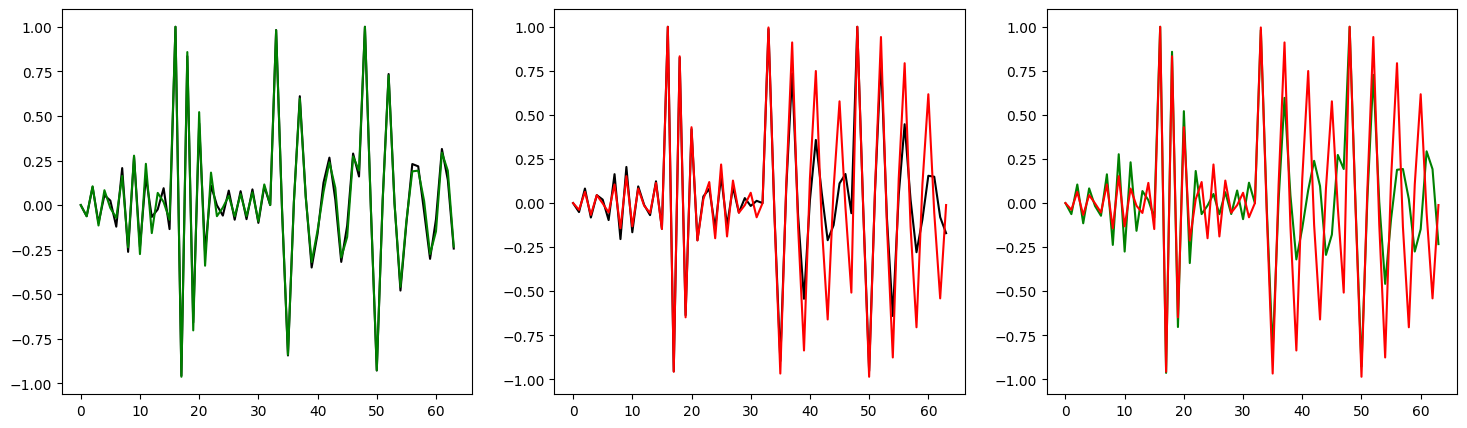

In [55]:
b = np.random.randint(0,B)
base_idx, cross_idx = np.random.randint(0, sample_points, (2,))

sample_point = sample_inputs[b, base_idx]
vec = vec_pred[b, cross_idx]

lin_pixel_solution, line_mask = calc_single_integral_vec_encoding(sample_point, vec, size, yx, emb_size, linear=True)
lin_integral_solution = line_encoding[b,base_idx, cross_idx]

shp_pixel_solution, shape_mask = calc_single_integral_vec_encoding(sample_point, vec, size, yx, emb_size, linear=False)
shp_integral_solution = shape_encoding[b,base_idx, cross_idx]

fig, axs = plt.subplots(1,3, figsize=(18,5))

axs[0].plot(lin_pixel_solution, color='black')
axs[0].plot(lin_integral_solution, color='green')

axs[1].plot(shp_pixel_solution, color='black')
axs[1].plot(shp_integral_solution, color='red')

axs[2].plot(lin_integral_solution, color='green')
axs[2].plot(shp_integral_solution, color='red')

(8, 5, 64) (8, 5, 64)


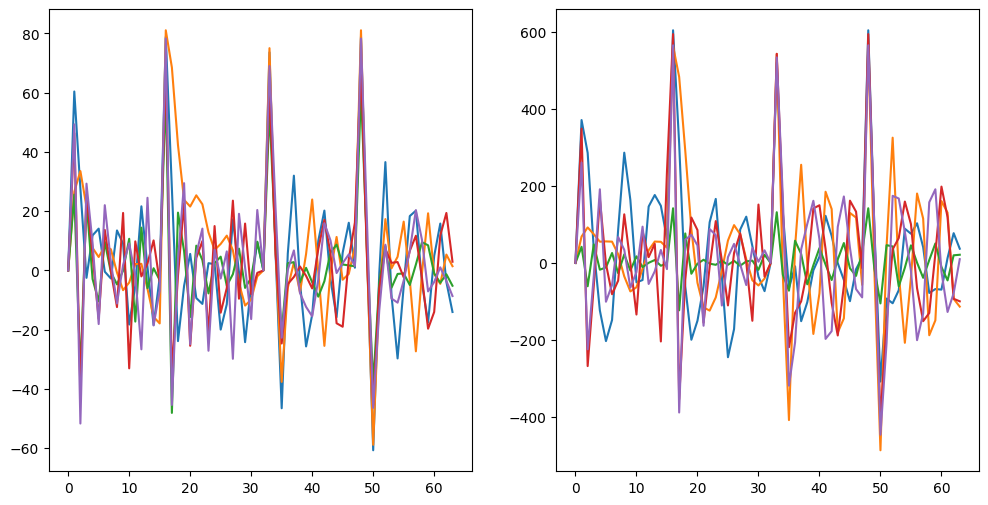

In [118]:
diag = (1-tf.linalg.diag(tf.ones(sample_points)))[tf.newaxis,...,tf.newaxis]

lin_enc_sum = tf.reduce_sum(line_encoding*diag, axis=-2)
shp_enc_sum = tf.reduce_sum(shape_encoding*diag, axis=-2)

print(lin_enc_sum.shape, shp_enc_sum.shape)

fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].plot(tf.transpose(lin_enc_sum[b], perm=[1,0]))
axs[1].plot(tf.transpose(shp_enc_sum[b], perm=[1,0]))
plt.show()

In [120]:
np.reshape(np.round(shape_rel_coords[b,base_idx, cross_idx]), (2,2)), np.round(vec)

(array([[-13.,  14.],
        [ -4.,  20.]], dtype=float32),
 array([[24., 22.],
        [15., 28.]], dtype=float32))

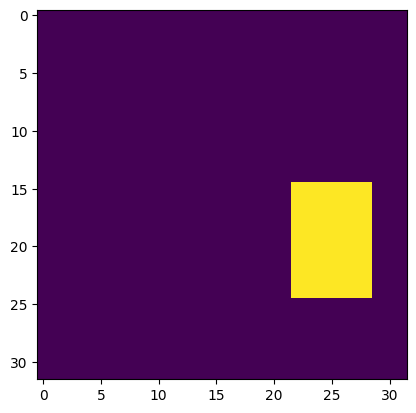

In [119]:
plt.imshow(shape_mask)

## vector addition

In [4]:
class IVREPostVariables(tf.keras.layers.Layer):

    def build(self, input_shape):

        n = input_shape[-3]
        self.diag = tf.expand_dims(tf.linalg.diag(tf.ones((n,))), axis=0)
        self.mask = tf.expand_dims(tf.expand_dims(self.diag*(-1e6), axis=-2), axis=-3)

        self.diag = tf.expand_dims(self.diag, axis=-2)

    def call(self, inputs):

        Q = tf.matmul(self.diag, inputs)

        return Q, self.mask

In [44]:
C = 64
size = 32

target_point = tf.constant(np.random.randint(0,size, (1,1,2)), tf.float32)
sample_points = tf.constant(np.random.randint(0,size, (1,2,2)), tf.float32)

direct_encoding = SampleFrequencyRadialEncoding(emb_dim=C, height=size, expand_b=False)(sample_points, target_point)
print('direct_encoding:', direct_encoding.shape)

direct_encoding = tf.reshape(direct_encoding, (2, C))
print('target_point:', target_point[0,].numpy())
print('sample_points:', sample_points[0].numpy())

direct_encoding: (1, 2, 1, 64)
target_point: [[13. 19.]]
sample_points: [[17.  8.]
 [ 0. 26.]]


In [42]:
middle_point = tf.reduce_mean(target_point, axis=-2, keepdims=True)
mid_direct_encoding = SampleFrequencyRadialEncoding(emb_dim=C, height=size, expand_b=False)(sample_points, middle_point)
mid_direct_encoding = tf.reshape(mid_direct_encoding, (2, C))
print(mid_direct_encoding.shape, direct_encoding.shape)

(2, 64) (2, 64)


In [37]:
radial_reg = C//4
shifts_num = C//2

dim_t = tf.range(radial_reg, dtype=tf.float32)
dim_freq = dim_t
dim_ph = dim_freq/(radial_reg)*math.pi*2
print('dim_freq:', dim_freq.shape)
print('dim_ph:', dim_ph.shape)

angle_sin_enc, angle_cos_enc, ring_sin_enc, ring_cos_enc = tf.split(direct_encoding, 4, axis=-1)
print('angle_enc:', angle_sin_enc.shape)
print('ring_enc:', ring_sin_enc.shape)

dim_freq: (16,)
dim_ph: (16,)
angle_enc: (2, 16)
ring_enc: (2, 16)


In [23]:
recon_sin_angle.shape

TensorShape([2, 16])

In [35]:
recon_sin_dist, recon_cos_dist

(<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
 array([[        nan, -0.7976321 , -0.01223387, -0.11866587, -0.3804652 ,
         -0.16931358, -0.11866587, -0.26826534, -0.20858344, -0.11866578,
         -0.22338553, -0.22643347, -0.1431335 , -0.19921952, -0.2366335 ,
         -0.16931364],
        [        nan,  0.31941855, -0.46597958, -0.18851888, -0.0732805 ,
         -0.3088999 , -0.1885189 , -0.12938035, -0.26963004, -0.18851893,
         -0.15182027, -0.25178012, -0.1885189 , -0.16390334, -0.24158008,
         -0.18851894]], dtype=float32)>,
 <tf.Tensor: shape=(2, 16), dtype=float32, numpy=
 array([[        nan,  0.7731642 ,  0.40493292, -0.11866588, -0.01223391,
          0.09077375, -0.1186659 , -0.12443375, -0.0122339 , -0.11866578,
         -0.16931358, -0.08363381, -0.11866587, -0.1934796 , -0.12443376,
         -0.11866568],
        [        nan,  0.85867864,  0.3194186 , -0.18851896,  0.07328053,
          0.00525935, -0.18851893, -0.03891928, -0.07328051, -0.18851891,

In [34]:
tf.asin(angle_sin_enc)

<tf.Tensor: shape=(2, 16), dtype=float32, numpy=
array([[ 0.        , -0.8563465 , -1.4289    , -0.57255244,  0.2837931 ,
         1.1401404 ,  1.1451048 ,  0.28875744, -0.56758606, -1.4239336 ,
        -0.86131173, -0.00496434,  0.85138315,  1.433866  ,  0.5775148 ,
        -0.27882877],
       [ 0.        , -0.9331182 , -1.2753563 , -0.34223816,  0.59088004,
         1.5239998 ,  0.6844764 , -0.24864188, -1.1817601 , -1.0267107 ,
        -0.09359246,  0.839522  ,  1.3689525 ,  0.43583438, -0.4972838 ,
        -1.4304019 ]], dtype=float32)>

In [38]:
recon_sin_angle = tf.tan((tf.asin(angle_sin_enc)-dim_ph)/dim_freq)-math.pi
recon_cos_angle = tf.tan((tf.acos(angle_cos_enc)-dim_ph)/dim_freq)-math.pi
recon_sin_dist = (tf.asin(ring_sin_enc)-dim_ph)/(2*dim_freq)
recon_cos_dist = (tf.acos(ring_cos_enc)-dim_ph)/(2*dim_freq)

sin_coords = tf.stack([recon_sin_dist*tf.sin(recon_sin_angle), recon_sin_dist*tf.cos(recon_sin_angle)], axis=-1)
cos_coords = tf.stack([recon_cos_dist*tf.sin(recon_cos_angle), recon_cos_dist*tf.cos(recon_cos_angle)], axis=-1)
sin_coords, cos_coords

(<tf.Tensor: shape=(2, 16, 2), dtype=float32, numpy=
 array([[[        nan,         nan],
         [-0.04091361,  0.03908454],
         [-0.18670873,  0.4086482 ],
         [ 0.05405545, -0.01671889],
         [-0.13089015,  0.30958435],
         [-0.01227677,  0.13456294],
         [-0.08528265,  0.1866576 ],
         [-0.14338177,  0.17324372],
         [-0.05442804,  0.12873444],
         [-0.0638455 ,  0.26722702],
         [-0.05615284,  0.12290143],
         [-0.12492406,  0.19194517],
         [-0.07300879,  0.17268205],
         [-0.05327068,  0.17724691],
         [-0.09345453,  0.20454334],
         [-0.07691447,  0.13209696]],
 
        [[        nan,         nan],
         [-0.32323098, -0.4724656 ],
         [-0.17892785, -0.01720674],
         [-0.12459531,  0.4236093 ],
         [-0.05268365,  0.20632581],
         [-0.04152655,  0.0373708 ],
         [-0.05072196,  0.17244865],
         [-0.10644113,  0.27185816],
         [-0.12023823,  0.17575175],
         [-0.035463

In [57]:
all_enc = tf.concat([direct_encoding, shifted_encoding[tf.newaxis]], axis=0)
cov = np.cov(all_enc)
std = np.std(all_enc, axis=-1, keepdims=False)
std_matrix = std[:,np.newaxis]*std[np.newaxis]
cov/std_matrix

array([[ 1.01587303,  0.11102214,  0.01630737],
       [ 0.11102214,  1.01587307, -0.05825207],
       [ 0.01630737, -0.05825207,  1.01587309]])

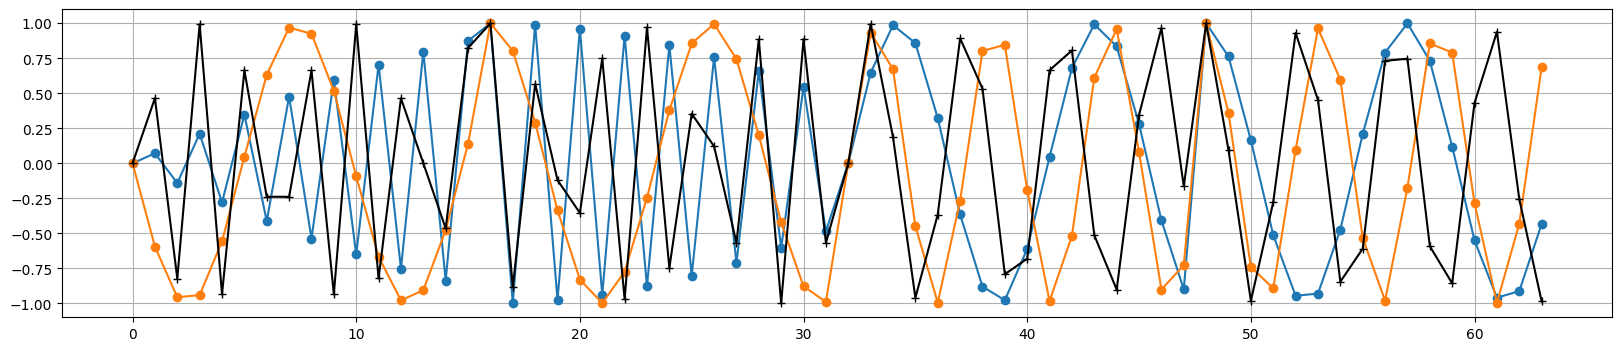

In [66]:
plt.figure(figsize=(20,4))
plt.plot(tf.transpose(direct_encoding, [1,0]), marker='o')
plt.plot(shifted_encoding, color='black', marker='+')
plt.grid()

# Fourier encoding

In [3]:
def calc_angles(a, b):
        return tf.math.atan2(*tf.split(a-b, 2, axis=-1))

yx: (32, 32, 2)
sample_point: [[[11.  5.]]]
sample_angles: (32, 32, 1)
vec_mask: (32, 32, 1) 1.0


(0.0, 31.0)

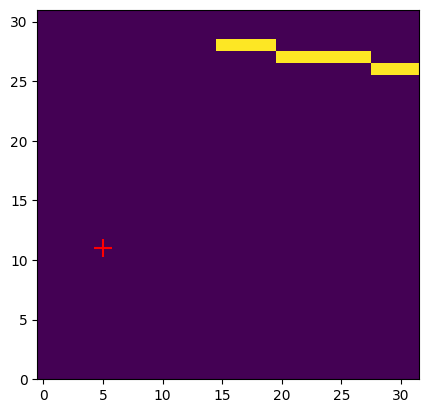

In [93]:
size = 32
yx = xy_coords((size, size))[...,::-1]
print('yx:', yx.shape)
sample_point = tf.constant(np.random.randint(0,size, (1,1,2)), tf.float32)
sample_vec = tf.constant(np.random.randint(0, size, (2,2)), tf.float32)
print('sample_point:', sample_point.numpy())

sample_angles = calc_angles(yx, sample_point)
print('sample_angles:', sample_angles.shape)

np_vec = np.round(sample_vec.numpy()[:,::-1], 0).astype(np.int32)
vec_mask = tf.constant(cv.line(np.zeros((size,size,1), np.int32), np_vec[0], np_vec[1], color=1, thickness=1), tf.float32)
vec_mask /= tf.reduce_sum(vec_mask)
print('vec_mask:', vec_mask.shape, np.sum(vec_mask))

plt.imshow(vec_mask)
plt.scatter(*sample_point[0,0,::-1], marker='+', color='red', s=150)
plt.ylim(0,31)

In [94]:
N = 16

angle_approx_vec = tf.linspace(0.0, 2*math.pi*(1-1/N), N)+(1/N-1)*math.pi
n_matrix = (sample_angles+math.pi)/(2*math.pi)*(N-1)
k_matrix = tf.range(N, dtype=tf.float32)[:,tf.newaxis]
complex_var = tf.complex(0.0,-1.0)

F = tf.squeeze(tf.matmul(tf.math.exp(complex_var*tf.cast(2*math.pi*tf.reshape(n_matrix, (1,-1))*k_matrix/N, tf.complex64)), tf.cast(tf.reshape(vec_mask, (-1,1)), tf.complex64)), axis=-1)
Fi = tf.math.real(tf.signal.ifft(F))
print(F.shape)

real_mean_angle = tf.atan2(*tf.split((tf.reduce_mean(sample_vec, axis=0)-sample_point[0,0]), 2, axis=0))/math.pi*180
fft_recon_angle = tf.math.atan2(tf.reduce_sum(tf.sin(angle_approx_vec)*Fi), tf.reduce_sum(tf.cos(angle_approx_vec)*Fi))/math.pi*180

print('real approx angle:', real_mean_angle[0].numpy())
print('fft recon angle:', fft_recon_angle.numpy())

(16,)
real approx angle: 41.63354
fft recon angle: 44.838905


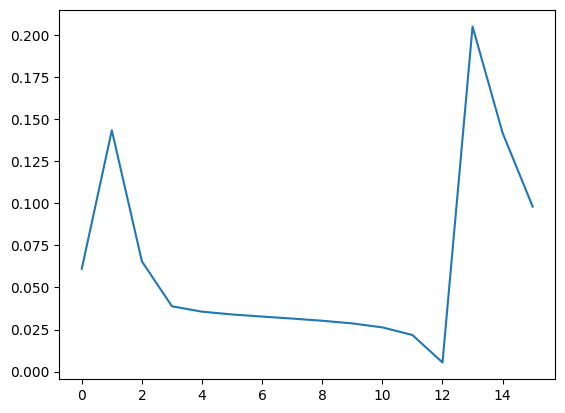

In [43]:
plt.plot(Fi)

In [39]:
np.sum(Fi)

1.0

(0.0, 31.0)

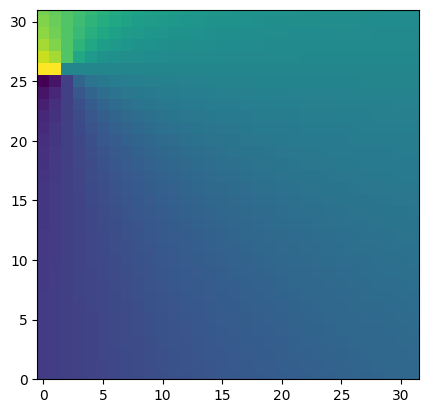

In [59]:
plt.imshow(sample_angles)
plt.ylim(0,31)